In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

from sklearn.metrics import confusion_matrix

In [2]:
dataset = tf.keras.utils.image_dataset_from_directory('/kaggle/input/intel-image-classification/seg_train/seg_train', label_mode='categorical', image_size=(128, 128))

Found 14034 files belonging to 6 classes.


In [3]:
data_iterator = dataset.as_numpy_iterator()

In [4]:
batch = data_iterator.next()

/opt/conda/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


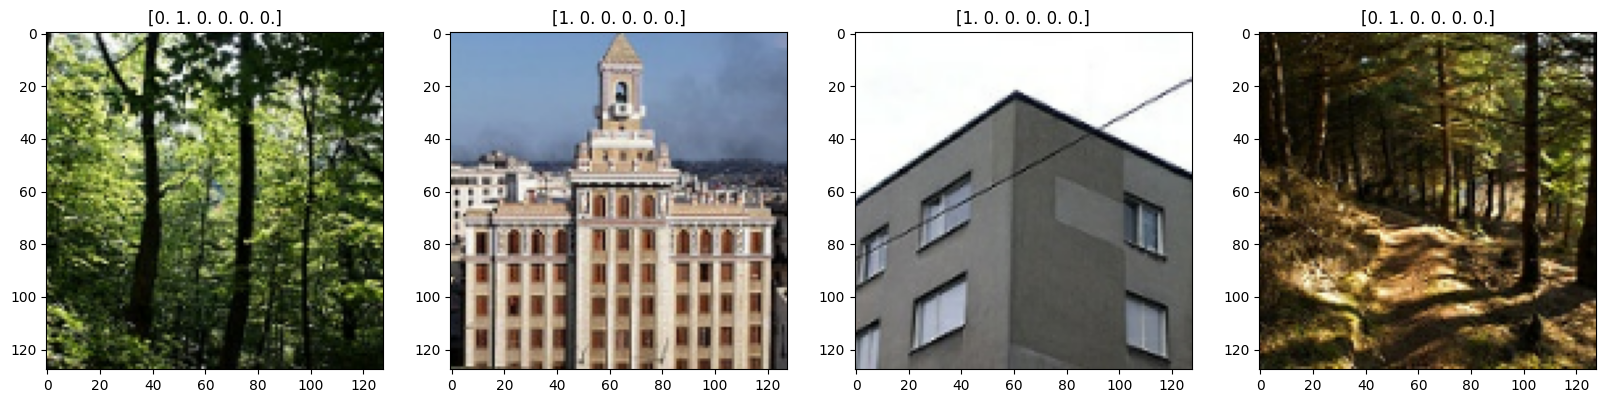

In [5]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [6]:
data = dataset.map(lambda x, y: (x/255, y))

In [7]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [8]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [9]:
model = Sequential()

In [10]:
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(128, 128, 3), kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), 1, activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), 1, activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

In [11]:
model.compile(optimizer=Adam(learning_rate=.001), loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0

In [13]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [14]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
307/307 [==============================] - 75s 239ms/step - loss: 1.4618 - accuracy: 0.5275 - val_loss: 1.1481 - val_accuracy: 0.5894
Epoch 2/10
307/307 [==============================] - 73s 237ms/step - loss: 1.1644 - accuracy: 0.6053 - val_loss: 1.1722 - val_accuracy: 0.5783
Epoch 3/10
307/307 [==============================] - 71s 231ms/step - loss: 1.1033 - accuracy: 0.6341 - val_loss: 1.0292 - val_accuracy: 0.6667
Epoch 4/10
307/307 [==============================] - 74s 241ms/step - loss: 1.0482 - accuracy: 0.6596 - val_loss: 0.9884 - val_accuracy: 0.6835
Epoch 5/10
307/307 [==============================] - 73s 236ms/step - loss: 1.0280 - accuracy: 0.6764 - val_loss: 0.9411 - val_accuracy: 0.7141
Epoch 6/10
307/307 [==============================] - 72s 235ms/step - loss: 0.9777 - accuracy: 0.7006 - val_loss: 0.9398 - val_accuracy: 0.7055
Epoch 7/10
307/307 [==============================] - 72s 235ms/step - loss: 0.9542 - accuracy: 0.7122 - val_loss: 0.8767 - val_ac

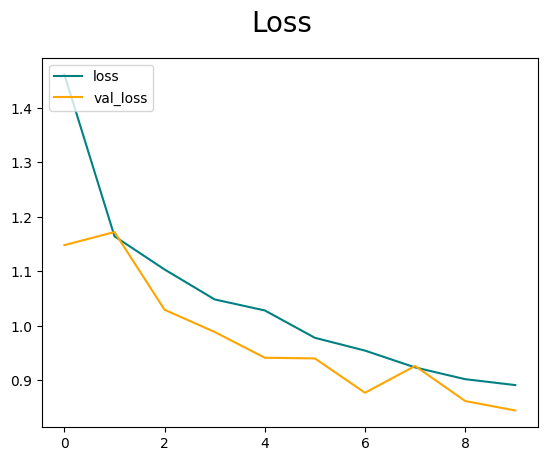

In [15]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

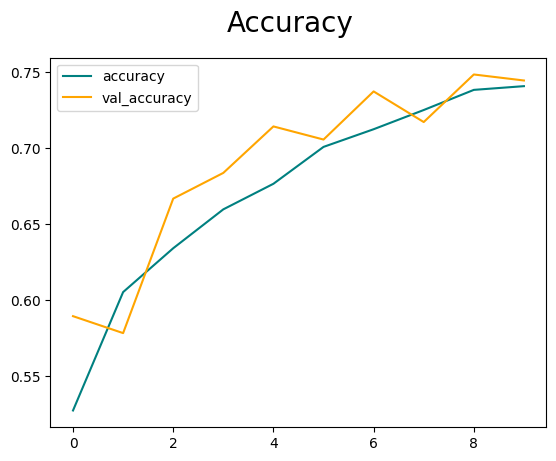

In [16]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [17]:
test_loss = model.evaluate(test)

43/43 [==============================] - 8s 59ms/step - loss: 0.8330 - accuracy: 0.7471


In [18]:
# Evaluate the model on the validation set
predictions = model.predict(test)
predicted_labels = np.argmax(predictions, axis=1)

test_labels = []
for _, label in test:
    test_labels.append(label.numpy())

decoded_test_labels = []
for arr in test_labels:
    decoded_test_labels.append(np.argmax(arr, axis=1))
    
decoded_test_labels = np.array(decoded_test_labels).flatten().tolist()

43/43 [==============================] - 9s 57ms/step


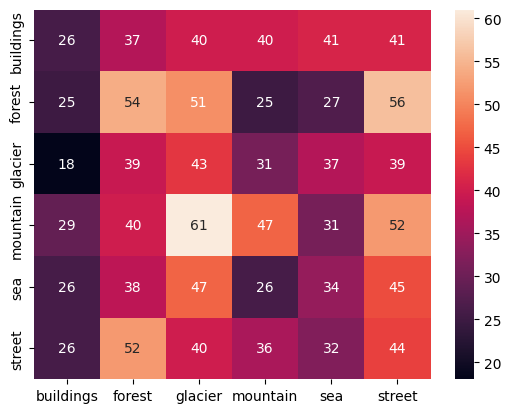

In [19]:
conf_matrix = confusion_matrix(decoded_test_labels, predicted_labels)

sns.heatmap(conf_matrix, annot=True, xticklabels=dataset.class_names, yticklabels=dataset.class_names)
plt.show()

In [20]:
# Error analysis
for i, j in zip(range(len(conf_matrix)), dataset.class_names):
    print(f"Class {j}:")
    true_positive = conf_matrix[i, i]
    false_positive = np.sum(conf_matrix[:, i]) - true_positive
    false_negative = np.sum(conf_matrix[i, :]) - true_positive

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print()

Class buildings:
  Precision: 0.1733
  Recall: 0.1156

Class forest:
  Precision: 0.2077
  Recall: 0.2269

Class glacier:
  Precision: 0.1525
  Recall: 0.2077

Class mountain:
  Precision: 0.2293
  Recall: 0.1808

Class sea:
  Precision: 0.1683
  Recall: 0.1574

Class street:
  Precision: 0.1588
  Recall: 0.1913



In [22]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

print(f'Precision: {precision.result()},\nRecall: {recall.result()},\nAccuracy: {accuracy.result()}')

Precision: 0.8005093336105347,
Recall: 0.6853197813034058,
Accuracy: 0.919089138507843


In [37]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

# Create your own model on top of VGG16
model2 = Sequential()
model2.add(base_model)
model2.add(Conv2D(32, (3, 3), 1, activation='relu', kernel_regularizer=l2(0.001)))
model2.add(MaxPooling2D())
model2.add(Flatten())
model2.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model2.add(Dropout(0.5))
model2.add(Dense(6, activation='softmax'))

model2.compile(optimizer=Adam(learning_rate=.001), loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [38]:
model2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 conv2d_16 (Conv2D)          (None, 2, 2, 32)          147488    
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 1, 1, 32)          0         
 ng2D)                                                           
                                                                 
 flatten_3 (Flatten)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 128)               4224      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                     

In [39]:
logdir2='logs2'
tensorboard_callback2 = tf.keras.callbacks.TensorBoard(log_dir=logdir2)

In [40]:
hist2 = model2.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback2])

Epoch 1/10
307/307 [==============================] - 1040s 3s/step - loss: 0.9555 - accuracy: 0.7600 - val_loss: 0.6179 - val_accuracy: 0.8560
Epoch 2/10
307/307 [==============================] - 1028s 3s/step - loss: 0.5666 - accuracy: 0.8629 - val_loss: 0.5140 - val_accuracy: 0.8725
Epoch 3/10
307/307 [==============================] - 1028s 3s/step - loss: 0.4627 - accuracy: 0.8895 - val_loss: 0.5032 - val_accuracy: 0.8610
Epoch 4/10
307/307 [==============================] - 1045s 3s/step - loss: 0.4228 - accuracy: 0.8961 - val_loss: 0.5264 - val_accuracy: 0.8538
Epoch 5/10
307/307 [==============================] - 1031s 3s/step - loss: 0.3838 - accuracy: 0.9093 - val_loss: 0.4860 - val_accuracy: 0.8689
Epoch 6/10
307/307 [==============================] - 1040s 3s/step - loss: 0.3627 - accuracy: 0.9143 - val_loss: 0.4884 - val_accuracy: 0.8700
Epoch 7/10
307/307 [==============================] - 1040s 3s/step - loss: 0.3494 - accuracy: 0.9186 - val_loss: 0.5250 - val_accuracy:

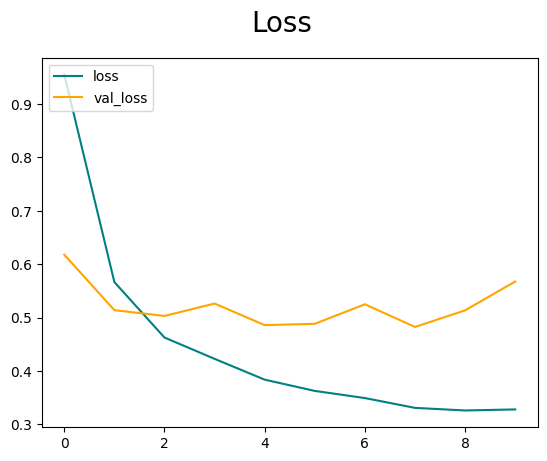

In [41]:
fig = plt.figure()
plt.plot(hist2.history['loss'], color='teal', label='loss')
plt.plot(hist2.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

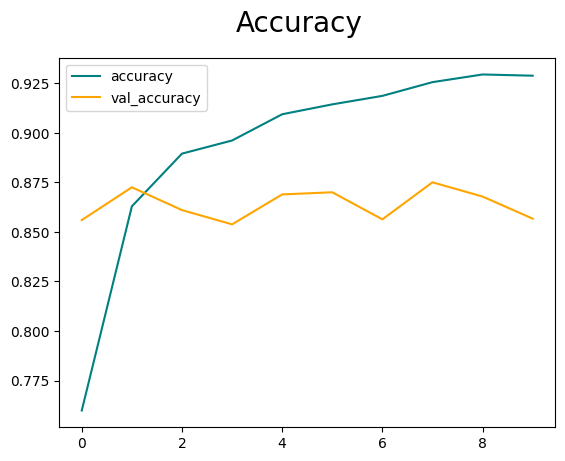

In [42]:
fig = plt.figure()
plt.plot(hist2.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist2.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [43]:
test_loss2 = model2.evaluate(test)

43/43 [==============================] - 113s 3s/step - loss: 0.5876 - accuracy: 0.8510


In [44]:
# Evaluate the model on the validation set
predictions2 = model2.predict(test)
predicted_labels2 = np.argmax(predictions2, axis=1)

test_labels2 = []
for _, label in test:
    test_labels2.append(label.numpy())

decoded_test_labels2 = []
for arr in test_labels2:
    decoded_test_labels2.append(np.argmax(arr, axis=1))
    
decoded_test_labels2 = np.array(decoded_test_labels2).flatten().tolist()

43/43 [==============================] - 113s 3s/step


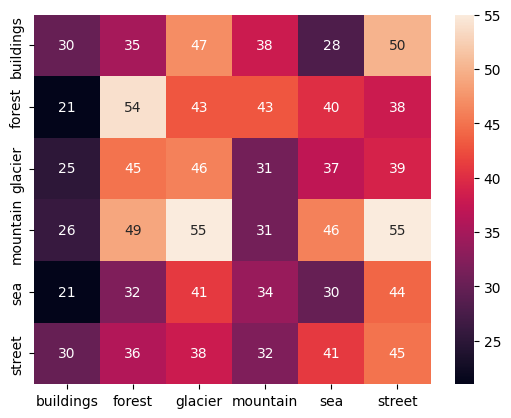

In [45]:
conf_matrix2 = confusion_matrix(decoded_test_labels2, predicted_labels2)

sns.heatmap(conf_matrix2, annot=True, xticklabels=dataset.class_names, yticklabels=dataset.class_names)
plt.show()

In [46]:
# Error analysis
for i, j in zip(range(len(conf_matrix2)), dataset.class_names):
    print(f"Class {j}:")
    true_positive = conf_matrix[i, i]
    false_positive = np.sum(conf_matrix[:, i]) - true_positive
    false_negative = np.sum(conf_matrix[i, :]) - true_positive

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print()

Class buildings:
  Precision: 0.1733
  Recall: 0.1156

Class forest:
  Precision: 0.2077
  Recall: 0.2269

Class glacier:
  Precision: 0.1525
  Recall: 0.2077

Class mountain:
  Precision: 0.2293
  Recall: 0.1808

Class sea:
  Precision: 0.1683
  Recall: 0.1574

Class street:
  Precision: 0.1588
  Recall: 0.1913



In [47]:
precision2 = Precision()
recall2 = Recall()
accuracy2 = BinaryAccuracy()

for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model2.predict(X)
    precision2.update_state(y, yhat)
    recall2.update_state(y, yhat)
    accuracy2.update_state(y, yhat)

print(f'Precision: {precision2.result()},\nRecall: {recall2.result()},\nAccuracy: {accuracy2.result()}')

1/1 [==============================] - 2s 2s/step
Precision: 0.8584136366844177,
Recall: 0.8415697813034058,
Accuracy: 0.9504602551460266
